<a href="https://colab.research.google.com/github/NeerajMehta15/Deep-Learning-projects/blob/main/1_LSTM_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [5]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [6]:
file_name = '/content/drive/MyDrive/Datasets/IMDB Dataset.csv'
df = pd.read_csv(file_name)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'train data shape: {x_train.shape}')
print(f'test data shape: {x_test.shape}')

train data shape: (37500,)
test data shape: (12500,)


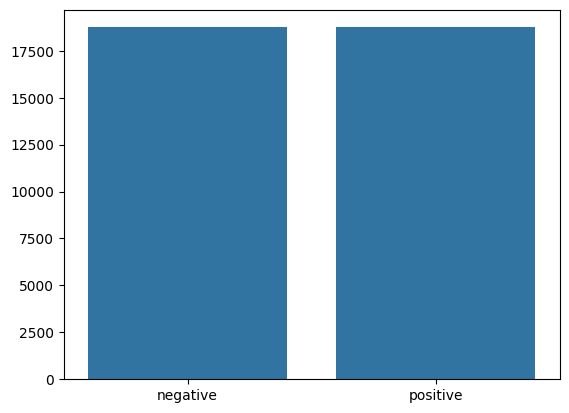

In [8]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [9]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence

def tokenize(x_train, y_train, x_val, y_val):
    word_list = []
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # Tokenize sentences
    final_list_train = [[onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()] for sent in x_train]
    final_list_test = [[onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()] for sent in x_val]

    # Convert to PyTorch tensors and pad sequences
    final_list_train = [torch.tensor(seq, dtype=torch.long) for seq in final_list_train]
    final_list_test = [torch.tensor(seq, dtype=torch.long) for seq in final_list_test]

    padded_train = pad_sequence(final_list_train, batch_first=True, padding_value=0)
    padded_test = pad_sequence(final_list_test, batch_first=True, padding_value=0)

    # Encode labels
    encoded_train = torch.tensor([1 if label == 'positive' else 0 for label in y_train], dtype=torch.float)
    encoded_test = torch.tensor([1 if label == 'positive' else 0 for label in y_val], dtype=torch.float)

    return padded_train, encoded_train, padded_test, encoded_test, onehot_dict


In [11]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

In [12]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


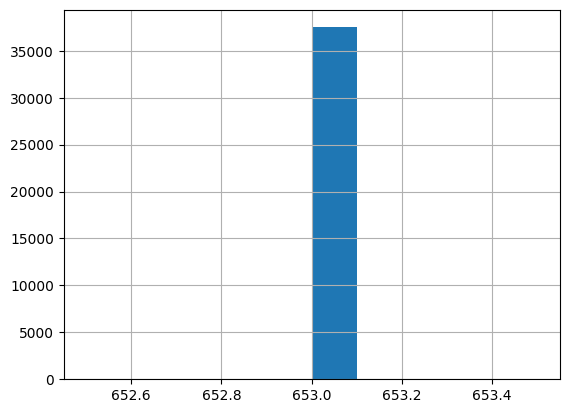

,0
count,37500.0
mean,653.0
std,0.0
min,653.0
25%,653.0
50%,653.0
75%,653.0
max,653.0


In [13]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [14]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [15]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [16]:
# Ensure tensors and correct shapes
x_train_pad = torch.tensor(x_train_pad, dtype=torch.float32)  # Adjust dtype if necessary
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1)  # Ensure 1D tensor

x_test_pad = torch.tensor(x_test_pad, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1)

# Create Tensor datasets
train_data = TensorDataset(x_train_pad, y_train)
valid_data = TensorDataset(x_test_pad, y_test)

# Dataloaders
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


<ipython-input-16-b09b471c9c8f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1)  # Ensure 1D tensor
<ipython-input-16-b09b471c9c8f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).view(-1)


In [17]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  7., 759.,   4.,  ...,   0.,   0.,   0.],
        [  3., 534., 155.,  ...,   0.,   0.,   0.],
        [149.,  17.,   2.,  ...,   0.,   0.,   0.],
        ...,
        [163.,  35., 313.,  ...,   0.,   0.,   0.],
        [590.,   3., 202.,  ...,   0.,   0.,   0.],
        [  2., 395., 288.,  ...,   0.,   0.,   0.]])
Sample output: 
 tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [18]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels


        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [19]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [20]:
# loss and optimization functions

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [21]:
# Define the accuracy function
def acc(predictions, labels):
    preds = torch.round(predictions)  # Convert probabilities to binary predictions
    correct = (preds == labels).float()  # Convert to float for division
    accuracy = correct.sum() / len(correct)
    return accuracy.item()

# Training loop
clip = 5
epochs = 5
valid_loss_min = np.Inf
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)  # Initialize hidden state

    for inputs, labels in train_loader:
        # Ensure inputs are of type `long` for the embedding layer
        inputs, labels = inputs.long().to(device), labels.to(device)

        # Detach hidden state to prevent backprop through entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()  # Clear gradients
        output, h = model(inputs, h)

        # Compute loss
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # Compute accuracy
        accuracy = acc(output.squeeze(), labels)
        train_acc += accuracy

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    # Validation loop
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()

    for inputs, labels in valid_loader:
        # Ensure inputs are of type `long` for the embedding layer
        inputs, labels = inputs.long().to(device), labels.to(device)
        val_h = tuple([each.data for each in val_h])

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())

        # Compute accuracy
        accuracy = acc(output.squeeze(), labels)
        val_acc += accuracy

    # Compute average losses and accuracies
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print epoch results
    print(f'Epoch {epoch + 1}')
    print(f'train_loss: {epoch_train_loss:.4f} val_loss: {epoch_val_loss:.4f}')
    print(f'train_accuracy: {epoch_train_acc * 100:.2f}% val_accuracy: {epoch_val_acc * 100:.2f}%')

    # Save model if validation loss decreases
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {epoch_val_loss:.6f}). Saving model ...')
        valid_loss_min = epoch_val_loss

    print('=' * 50)


Epoch 1
train_loss: 0.6936 val_loss: 0.6932
train_accuracy: 1.00% val_accuracy: 1.00%
Validation loss decreased (inf --> 0.693210). Saving model ...
Epoch 2
train_loss: 0.6933 val_loss: 0.6931
train_accuracy: 0.99% val_accuracy: 1.00%
Validation loss decreased (0.693210 --> 0.693150). Saving model ...
Epoch 3
train_loss: 0.6932 val_loss: 0.6932
train_accuracy: 1.00% val_accuracy: 1.00%
Epoch 4
train_loss: 0.6932 val_loss: 0.6945
train_accuracy: 1.00% val_accuracy: 1.00%
Epoch 5
train_loss: 0.6933 val_loss: 0.6932
train_accuracy: 1.01% val_accuracy: 1.00%


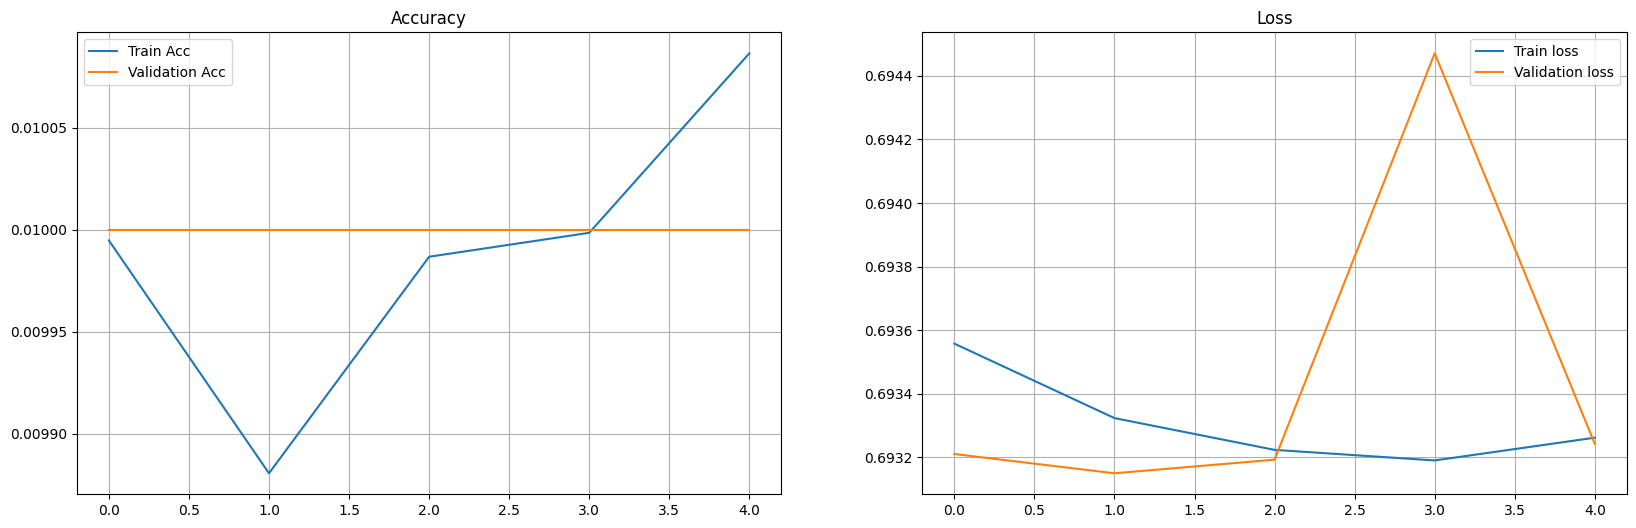

In [22]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [23]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [24]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

In [25]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as "Spider Baby". The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in motion), but everything else in the movie is slow, ponderous &, ultimately, unfulfilling. Adding insult to injury: the movie was dubbed, not subtitled, as promised on the video jacket.
Actual sentiment is  : negative
predicted sentiment is positive with a probability of 0.5369284152984619
